# **0. Import python  packages**






In [193]:
!pip install cartopy
import cartopy

In [194]:
# it working with labeled, multi-dimensional arrays, particularly for scientific data like NetCDF files
import xarray as xr

# library for numerical computations in Python
import numpy as np

# plotting library and its visualizations like line plots, scatter plots
import matplotlib.pyplot as plt

# library for geospatial plotting and its defines map projections
import cartopy.crs as ccrs

# its provides access to pre-defined geographic features
import cartopy.feature as cfeature

# to format latitude and longitude labels on the map axes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# **1.  Read the NetCDF file**

In [195]:
# 1. Read the NetCDF file ------------------------------------------------------

ds = xr.open_dataset('IBTrACS.last3years.v04r01.nc')

# **2. Filter data for 2024 and Western Pacific basin**

<function matplotlib.pyplot.show(close=None, block=None)>

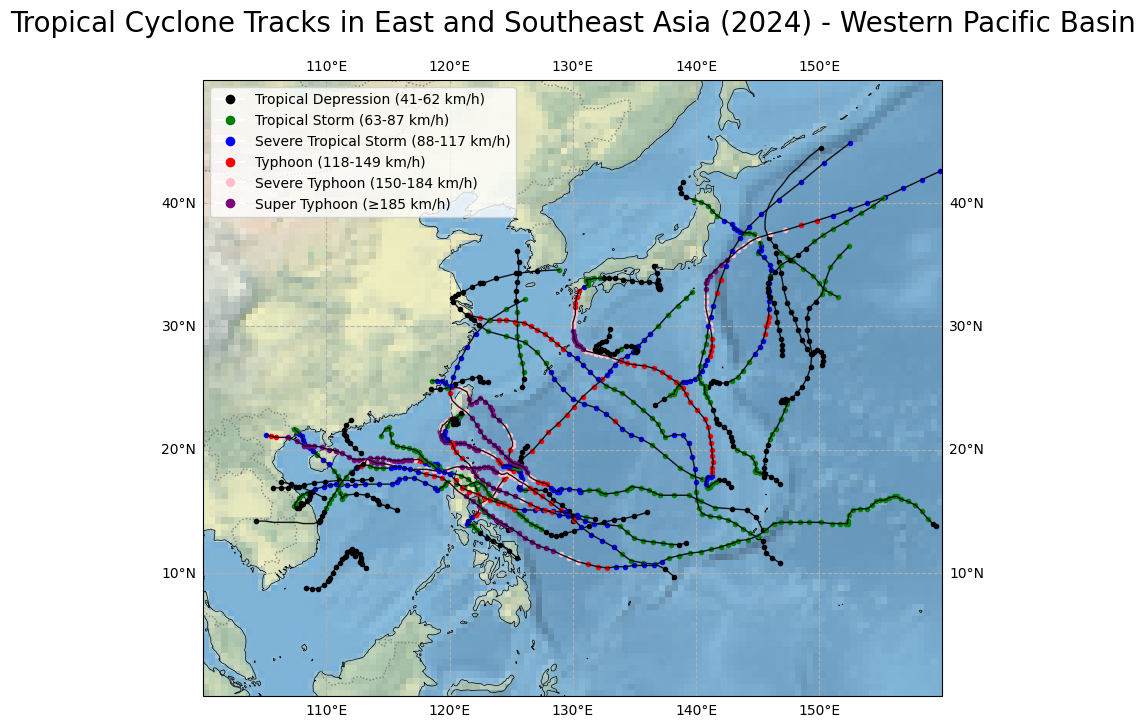

In [196]:
# 2. Filter data for 2024 and Western Pacific basin-----------------------------
# Convert time to datetime
# removes any null values using .notnull() and drops them
time = ds['time'].where(ds['time'].notnull(), drop=True)

# extracts the year from each time array
years = time.dt.year

# decode it and ensures it is stored as regular strings
if ds['basin'].dtype == 'S1':
    basin_per_storm = []
    for row in ds['basin'].values:
        basin_str = ''
        for i in range(0, len(row), 2):
            if row[i] != b'':
                char1 = row[i].decode('utf-8')
                char2 = row[i+1].decode('utf-8')
                basin_str = char1 + char2
                break
        basin_per_storm.append([basin_str] * len(row))
    basin = xr.DataArray(
        np.array(basin_per_storm, dtype=str),
        dims=ds['basin'].dims,
        coords=ds['basin'].coords
    )
else:
    basin = ds['basin']

# identifies which storms had at least one observation in the year 2024
# and which storms were in the WP basin at any point during their lifecycle
mask_2024 = (years == 2024).any(dim='date_time')
mask_wp = (basin == b'WP').any(dim='date_time')

# Get relevant storms by finds the indices of True values in two array
storms_2024 = np.where(mask_2024)[0]
storms_wp = np.where(mask_wp)[0]

# The storm occurred in 2024 and in the WP basin
storm_mask = mask_2024 & mask_wp
storm_indices = np.where(storm_mask)[0]



# 3. Set up the map ------------------------------------------------------------

# Creates a new figure for plot that 12 is the width, 8 is the height
fig = plt.figure(figsize=(12, 8))

# map projection as Plate Carree, then adds an “axes”
ax = plt.axes(projection=ccrs.PlateCarree())

# [west_longitude, east_longitude, south_latitude, north_latitude] which set to East and Southeast Asia
ax.set_extent([100, 160, 0, 50], crs=ccrs.PlateCarree())

# add Natural Earth shaded relief background
ax.stock_img()  # Adds a default shaded relief image from Natural Earth

# add coastline into map
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.5)

# add country boarders into map
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray')

# add latitude and longitude gridlines into map with labels
ax.gridlines(draw_labels=True, linestyle='--', alpha=1)

# add a title
plt.title('Tropical Cyclone Tracks in East and Southeast Asia (2024) - Western Pacific Basin',
          pad=20,
          fontsize=20)



# 4. Plot cyclone tracks with intensity ----------------------------------------

# define the color regrading to the level
colors = {
    'TD': 'black',          # Tropical Depression
    'TS': 'green',          # Tropical Storm
    'STS': 'blue',          # Severe Tropical Storm
    'TY': 'red',            # Typhoon
    'STY': 'pink',          # Severe Typhoon
    'SuperTY': 'purple'     # Super Typhoon
}

# plot cyclone tracks
for storm_idx in storm_indices: # set name of storm_indices array to "storm_idx"
  # Extract latitude coordinates for the current storm (one latitude value per time step)
  lat = ds['lat'][storm_idx].where(ds['lat'][storm_idx].notnull(), drop=True)

  # Extract longitude coordinates for the current storm (one longitude value per time step)
  lon = ds['lon'][storm_idx].where(ds['lon'][storm_idx].notnull(), drop=True)

  # Extract wind speed (in knots) for the current storm (one wind speed value per time step)
  # This step does not filter out NaN values yet; that’s handled later.
  wind_knots = ds['usa_wind'][storm_idx]

  # Skip the storm if wind_knots is empty
  if len(wind_knots) == 0:
      continue

  # Ensure lat, lon, and wind_knots have the same length
  min_length = min(len(lat), len(lon), len(wind_knots))
  if min_length == 0:
      continue

  lat = lat[:min_length]
  lon = lon[:min_length]
  wind_knots = wind_knots[:min_length]
  # # Convert wind speed from knots to km/h
  wind_kmh = wind_knots * 1.852

  for i in range(len(wind_kmh)):
    wind_speed = wind_kmh[i]
    if np.isnan(wind_speed): # checks if the wind speed is NaN
        continue

    if wind_speed < 41:
        intensity = 'TD'
    elif 41 <= wind_speed <= 62:
        intensity = 'TD'
    elif 63 <= wind_speed <= 87:
        intensity = 'TS'
    elif 88 <= wind_speed <= 117:
        intensity = 'STS'
    elif 118 <= wind_speed <= 149:
        intensity = 'TY'
    elif 150 <= wind_speed <= 184:
        intensity = 'STY'
    elif 185 <= wind_speed:
        intensity = 'SuperTY'
    # Plot the Point
    ax.plot(lon[i],lat[i], marker='o', markersize=3, color=colors[intensity], transform=ccrs.PlateCarree())
  # Plot the Line
  ax.plot(lon,lat,linewidth=1, color='black', alpha=0.9, transform=ccrs.PlateCarree())

# 5. Add legend ----------------------------------------------------------------

legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='Tropical Depression (41-62 km/h)', markerfacecolor='black', markersize=8),
    plt.Line2D([0], [0], marker='o', color='w', label='Tropical Storm (63-87 km/h)', markerfacecolor='green', markersize=8),
    plt.Line2D([0], [0], marker='o', color='w', label='Severe Tropical Storm (88-117 km/h)', markerfacecolor='blue', markersize=8),
    plt.Line2D([0], [0], marker='o', color='w', label='Typhoon (118-149 km/h)', markerfacecolor='red', markersize=8),
    plt.Line2D([0], [0], marker='o', color='w', label='Severe Typhoon (150-184 km/h)', markerfacecolor='pink', markersize=8),
    plt.Line2D([0], [0], marker='o', color='w', label='Super Typhoon (≥185 km/h)', markerfacecolor='purple', markersize=8)
]
ax.legend(handles=legend_elements, loc='upper left')

# 6. Result ----------------------------------------------------------------
plt.show